<a href="https://colab.research.google.com/github/utkuyucel/Deep-Learning/blob/master/89_Accuracy_with_New_Residual_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from keras.utils import plot_model
import os

(X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_test /= 255
X_train /= 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


In [2]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.32.232.42:8470


In [0]:
def short(X_input, F1, F2, F3, F4):
  
  X = tf.keras.layers.Conv2D(F1, (3,3), strides = (1,1), padding = "same")(X_input)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation("relu")(X)
  
  X = tf.keras.layers.Conv2D(F2, (3,3), strides = (1,1), padding = "same")(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation("relu")(X)

  X = tf.keras.layers.Conv2D(F3, (3,3), strides = (1,1), padding = "same")(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation("relu")(X)
  
  X = tf.keras.layers.Conv2D(F4, (3,3), strides = (1,1), padding = "same")(X)
  X = tf.keras.layers.BatchNormalization()(X)
  
  
  L = tf.keras.layers.concatenate([X,X_input])
  
  L = tf.keras.layers.Activation("relu")(L)
  
  L = tf.keras.layers.MaxPooling2D((2,2))(L)
  
  return L

In [0]:
def model(X_input):
  
  X_input = tf.keras.layers.Input(X_input)
  
  X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
  
  X = short(X, 64, 64, 64, 128)
  X = short(X, 128, 128, 128, 256)
  X = short(X, 256, 256, 256, 512) 
  
  
  FC = tf.keras.layers.AveragePooling2D(2,2)(X)
  
  F = tf.keras.layers.Flatten()(FC)
  
  FC = tf.keras.layers.Dense(10, activation = "softmax")(F)
  
  
  model = tf.keras.models.Model(inputs = X_input, outputs = FC)
  
  return model

In [5]:
model = model((32,32,3))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 38, 38, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 38, 38, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

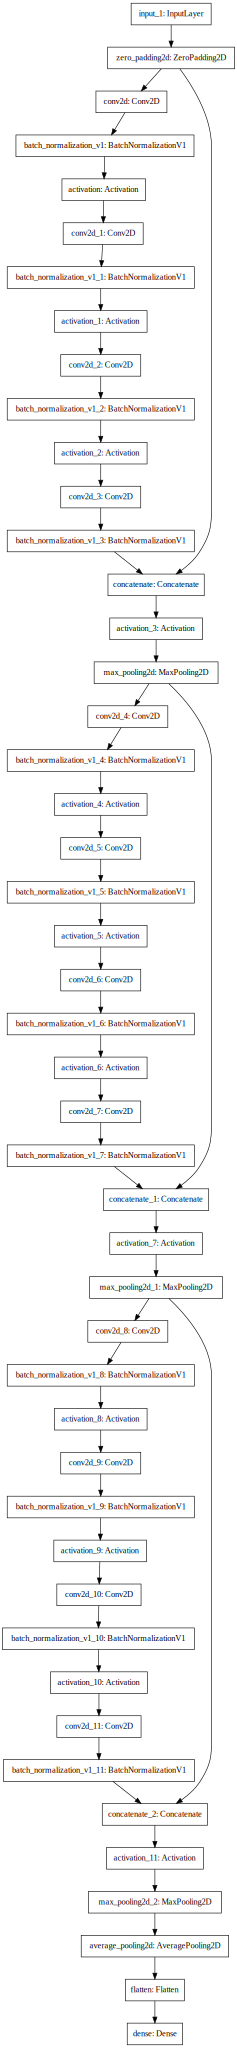

In [7]:
from matplotlib import pyplot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [8]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

#tpu_model.load_weights("./MNIST_TPU_1024.h5")


tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, X_train.shape[0] - batch_size)
    yield X_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    

history = tpu_model.fit_generator(
    train_gen(1024),
    epochs=50,
    steps_per_epoch=100,
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.32.232.42:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15857078998064548614)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9038906979929784105)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10956493310684821193)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

In [9]:
tpu_model.save_weights('./MNIST_TPU_1024.h5', overwrite=True)


INFO:tensorflow:Copying TPU weights to the CPU


In [10]:
tpu_model.evaluate(X_test, y_test, steps = 100)

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1250,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(1250, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(1250, 10), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 11.020620107650757 secs
100/100 [==============================] - 91s 908ms/step - loss: 0.6681 - acc: 0.8904


[0.6681042909622192, 0.8904]

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='input_1_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.545764923095703 secs


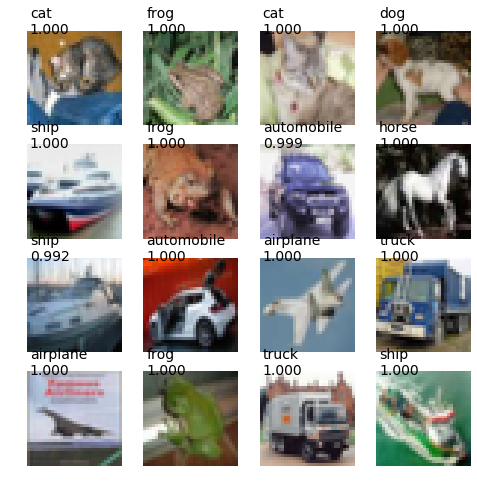

In [11]:
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


cpu_model = tpu_model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(X_test[:16]), 
                 tpu_model.predict(X_test[:16]))